# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.tree import DecisionTreeRegressor
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, callbacks
from scipy.stats import pearsonr
import seaborn as sns
import tensorflow as tf

# Conversion of MATLAB data into dataframe format

In [2]:
def load_data(battery):
    mat = loadmat("C:/Users/Public/Ai Mini Project/Nasa/1. BatteryAgingARC-FY08Q4/" + battery + '.mat')
    print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
    counter = 0
    dataset = []
    capacity_data = []

    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge':
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(int(row['time'][0][0]),
                                          int(row['time'][0][1]),
                                          int(row['time'][0][2]),
                                          int(row['time'][0][3]),
                                          int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                voltage_measured, current_measured,
                                temperature_measured, current_load,
                                voltage_load, time])
            capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
            counter = counter + 1

    return [pd.DataFrame(data=dataset,
                         columns=['cycle', 'ambient_temperature', 'datetime',
                                  'capacity', 'voltage_measured',
                                  'current_measured', 'temperature_measured',
                                  'current_load', 'voltage_load', 'time']),
            pd.DataFrame(data=capacity_data,
                         columns=['cycle', 'ambient_temperature', 'datetime',
                                  'capacity'])]

Load battery aging data from a MATLAB file using the loadmat() function.

Extract specific information for each cycle, including ambient temperature, date and time, capacity, and various measurements.

Store the information in two Pandas dataframes: one containing all information extracted from each cycle, and the other containing only the capacity data.

Return the two dataframes, both with the same columns: cycle, ambient_temperature, datetime, capacity, voltage_measured, current_measured, temperature_measured, current_load, voltage_load, and time.

# Model for Battery 0005

## Importing Capacity dataset

In [3]:
dataset, capacity = load_data('B0005')

Total data in dataset:  616


In [4]:
capacity

,cycle,ambient_temperature,datetime,capacity
0,1,24,2008-04-02 15:25:41,1.856487
1,2,24,2008-04-02 19:43:48,1.846327
2,3,24,2008-04-03 00:01:06,1.835349
3,4,24,2008-04-03 04:16:37,1.835263
4,5,24,2008-04-03 08:33:25,1.834646
...,...,...,...,...
163,164,24,2008-05-26 10:44:38,1.293464
164,165,24,2008-05-26 15:30:43,1.288003
165,166,24,2008-05-26 20:21:04,1.287453
166,167,24,2008-05-27 15:52:41,1.309015


## Getting Shape and size of the Dataset

In [5]:
print("Size of Data: ", capacity.size)
print("Shape of Data: ", capacity.shape)

Size of Data:  672
Shape of Data:  (168, 4)


In [6]:
capacity.describe()

,cycle,ambient_temperature,capacity
count,168.000000,168.0,168.000000
mean,84.500000,24.0,1.572502
std,48.641546,0.0,0.190413
min,1.000000,24.0,1.287453
25%,42.750000,24.0,1.390021
50%,84.500000,24.0,1.557085
75%,126.250000,24.0,1.769163
max,168.000000,24.0,1.856487


In [7]:
capacity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   cycle                168 non-null    int64         
 1   ambient_temperature  168 non-null    int8          
 2   datetime             168 non-null    datetime64[ns]
 3   capacity             168 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), int8(1)
memory usage: 4.2 KB


## Exploaratory Data Analysis

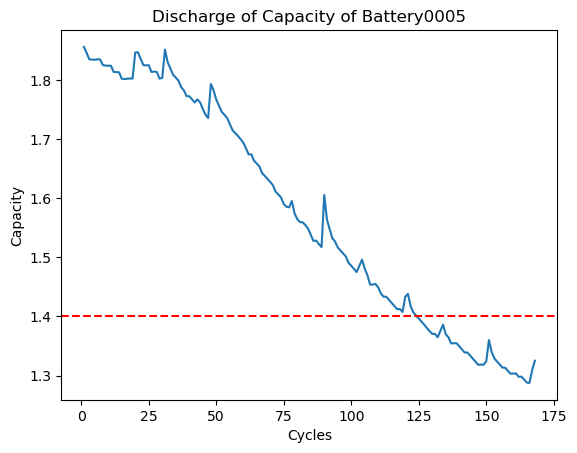

In [8]:
plt.plot(capacity['cycle'], capacity['capacity'])
plt.xlabel('Cycles')
plt.ylabel('Capacity')
plt.title('Discharge of Capacity of Battery0005')
plt.axhline(y=1.4, color='r', linestyle='--')

## Feature selection on basis of Correaltion between variables

In [9]:
corr = capacity['cycle'].corr(capacity['capacity'])
corr

-0.9877389295279454

The Pearson correlation coefficient is a measure of linear correlation between two variables.

It ranges from -1 to 1, where -1 indicates a perfect negative correlation and 1 indicates a perfect positive correlation.

A value of 0 indicates no correlation between the variables.

The correlation coefficient in this case is -0.9877389295279454, which is close to -1.

This indicates a strong negative correlation between cycle and capacity in the capacity DataFrame.

Specifically, as the cycle variable increases, the capacity variable decreases at a strong rate.

In [10]:
cormat = capacity.corr()
round(cormat,2)

,cycle,ambient_temperature,capacity
cycle,1.00,NaN,-0.99
ambient_temperature,NaN,NaN,NaN
capacity,-0.99,NaN,1.00


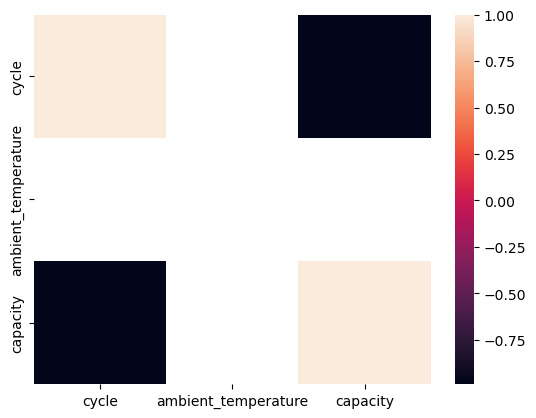

In [11]:
sns.heatmap(cormat);

##Calculating SOH Column for battery

In [12]:
capacity['SOH'] = capacity['capacity'] / capacity['capacity'][0]
capacity

,cycle,ambient_temperature,datetime,capacity,SOH
0,1,24,2008-04-02 15:25:41,1.856487,1.000000
1,2,24,2008-04-02 19:43:48,1.846327,0.994527
2,3,24,2008-04-03 00:01:06,1.835349,0.988614
3,4,24,2008-04-03 04:16:37,1.835263,0.988567
4,5,24,2008-04-03 08:33:25,1.834646,0.988235
...,...,...,...,...,...
163,164,24,2008-05-26 10:44:38,1.293464,0.696726
164,165,24,2008-05-26 15:30:43,1.288003,0.693785
165,166,24,2008-05-26 20:21:04,1.287453,0.693488
166,167,24,2008-05-27 15:52:41,1.309015,0.705103


capacity['capacity'][0] selects the first value in the capacity column.

capacity['capacity'] / capacity['capacity'][0] divides each value in the capacity column by the first value in the capacity column.

capacity['SOH'] creates a new column in the capacity DataFrame called SOH (State of Health).

The new SOH column contains the result of dividing each value in the capacity column by the first value in the capacity column, giving a measure of the relative health of the battery at each cycle.

## Visualization of SOH with respect to number of Cycles

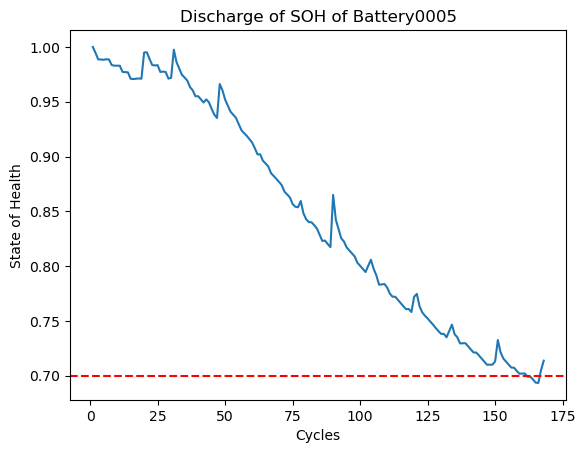

In [13]:
plt.plot(capacity['cycle'], capacity['SOH'])
plt.xlabel('Cycles')
plt.ylabel('State of Health')
plt.title('Discharge of SOH of Battery0005')
plt.axhline(y=0.7, color='r', linestyle='--')

## Data Preparation for model training and Evalution

In [14]:
X = capacity[['cycle', 'capacity']].values
y = capacity['SOH'].values

## Scaling Features

In [15]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

StandardScaler() is a class from the sklearn.preprocessing module that standardizes features by removing the mean and scaling to unit variance.
scaler = StandardScaler() creates an instance of the StandardScaler() class called scaler.
scaler.fit_transform(X) standardizes the features in X by subtracting the mean and scaling to unit variance. The result is a NumPy array or Pandas DataFrame of the same shape as X.

## Using train-test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

## DNN model

Deep Neural Networks (DNNs) are a class of neural networks that have multiple layers between the input and output layers. Each layer consists of multiple neurons that perform a nonlinear transformation on the input data, allowing for the learning of more complex and abstract representations. This allows the model to capture higher-level features that may be difficult to express in a shallow network.

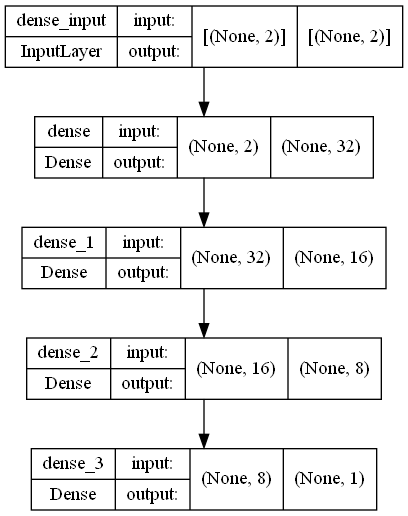

In [17]:
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(2,)),
    layers.Dense(16, activation='relu', kernel_regularizer='l2'),
    layers.Dense(8, activation='linear', kernel_regularizer='l2'),
    layers.Dense(1)
])
plot_model(model, to_file='model_circular.png', show_shapes=True, show_layer_names=True)

The code uses the Keras library to create a neural network model with 4 fully connected layers. The first layer has a ReLU activation function, while the remaining layers have no activation function. The second and third layers have L2 regularization applied to their weights. The input to the model has 2 features, and the output is a single value.

The ReLU activation function introduces non-linearity in the network by only allowing positive values to pass through and setting negative values to zero. This helps to capture complex, non-linear relationships in the data being modeled.

The linear activation function is used in the third hidden layer of the model, and it is a simple identity function that outputs the same value as the input. It is commonly used in the final layer of a regression neural network to predict continuous output values without any constraint on the predicted range.

L2 regularization is a technique used to prevent overfitting in machine learning models by adding a penalty term to the loss function. It is achieved by adding a weight decay term proportional to the sum of the squared weights in the model. The regularization parameter, also known as the lambda parameter, determines the strength of the regularization and is set to a default value of 0.01. The model is defined using the Keras Sequential() class and contains four fully connected layers with 32, 16, 8, and 1 neurons. The first layer uses the ReLU activation function and takes an input of shape (2,2).

The second and third layers use the linear activation function and apply L2 regularization to their weights. The fourth layer has no activation function and serves as the output layer of the model

In [18]:
model.compile(optimizer='sgd', loss='mean_absolute_error', metrics=['mae', 'mse'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 2s 46ms/step - loss: 1.3027 - mae: 0.9648 - mse: 0.9410 - val_loss: 1.1909 - val_mae: 0.8536 - val_mse: 0.7332
Epoch 2/100
5/5 [==============================] - 0s 11ms/step - loss: 1.1323 - mae: 0.7953 - mse: 0.6381 - val_loss: 1.0202 - val_mae: 0.6838 - val_mse: 0.4701
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 0.9659 - mae: 0.6297 - mse: 0.4003 - val_loss: 0.8534 - val_mae: 0.5177 - val_mse: 0.2695
Epoch 4/100
5/5 [==============================] - 0s 13ms/step - loss: 0.8011 - mae: 0.4657 - mse: 0.2192 - val_loss: 0.6840 - val_mae: 0.3489 - val_mse: 0.1224
Epoch 5/100
5/5 [==============================] - 0s 11ms/step - loss: 0.6316 - mae: 0.2967 - mse: 0.0902 - val_loss: 0.5074 - val_mae: 0.1728 - val_mse: 0.0311
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 0.4575 - mae: 0.1231 - mse: 0.0189 - val_loss: 0.3782 - val_mae: 0.0442 - val_mse: 0.0032
Epoch 7/100
5/5 [===========

The optimizer is a crucial component that adjusts the weights of the neural network to minimize the loss function. 

SGD (Stochastic Gradient Descent) is a widely used optimization algorithm for training neural networks. It updates the weights in the direction of the negative gradient of the loss function with respect to the weights. 

Adam (Adaptive Moment Estimation) is another popular optimization algorithm that combines the benefits of both Momentum and RMSProp optimizers. It has adaptive learning rates that improve convergence speed and can handle non-stationary objectives.

Early Stopping is a technique used to prevent overfitting of the model. It monitors the validation loss and stops the training process if it does not improve after a certain number of epochs. The monitor parameter is set to 'val_loss' and the patience parameter is set to 10. If the validation loss does not improve after 10 epochs, the training process will be stopped.

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


Learning Points:

Activation function: A mathematical function applied to each neuron output to introduce nonlinearity in the model.

Backpropagation: An algorithm that iteratively adjusts the weights of a neural network based on the error between predicted and actual output.

CNNs: Neural networks used for image recognition and computer vision tasks that use convolutional layers to extract features.

Dropout: A regularization technique that prevents overfitting in neural networks by randomly dropping out some neurons during training.

Gradient descent: An optimization algorithm that minimizes the loss function of a neural network by adjusting the weights of the network in the direction of the negative gradient of the loss function.

Loss function: A mathematical function that measures the difference between predicted and actual output in a neural network.

RNNs: Neural networks used for sequential data processing tasks, such as NLP and speech recognition, that use recurrent layers to maintain an internal state.

Transfer Learning: A technique that uses a pre-trained neural network as a starting point for a new task, and fine-tunes it on new data.

Vanishing gradient problem: A problem that occurs in deep neural networks when the gradient of the loss function becomes very small in the early layers, making it difficult to update the weights.

Weight initialization: The process of setting the initial values of the weights in a neural network to speed up convergence and prevent the vanishing gradient problem.

## Learning Curve

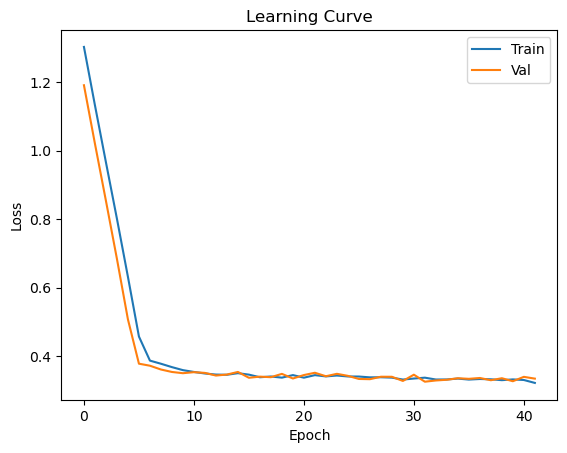

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

The learning curve is a tool used to measure the training and validation loss or accuracy of a model. The training loss/accuracy measures the performance of the model on the training data, while the validation loss/accuracy measures the performance of the model on a held-out validation set. As the training data size increases, the model is able to learn more patterns and generalize better to unseen data, resulting in lower training and validation loss or higher accuracy. The learning curve can help identify issues such as underfitting or overfitting, which can lead to high training and validation loss.

## Model Predicition

In [21]:
y_pred = model.predict(X_test)

## Visulization of Model Prediction

In [22]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()}).sort_values('Actual',ascending=False)
df

,Actual,Predicted
32,0.995114,1.028661
18,0.989060,1.024746
14,0.988614,1.046091
25,0.983460,1.020249
3,0.983100,1.019384
17,0.977528,1.012692
13,0.977098,1.011033
19,0.972056,0.999540
0,0.971063,1.007089
4,0.955050,0.984559


In [23]:
Sample_size=np.arange(0,df.shape[0],1)
Sample_size

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

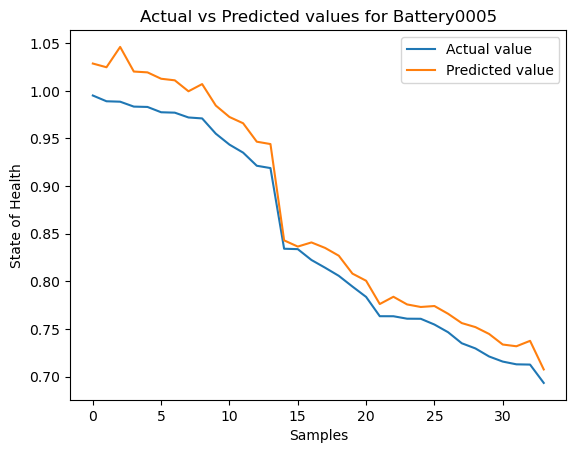

In [24]:
plt.plot(Sample_size, df['Actual'], label='Actual value')
plt.plot(Sample_size, df['Predicted'], label='Predicted value')

plt.title('Actual vs Predicted values for Battery0005')
plt.ylabel('State of Health')
plt.xlabel('Samples')
plt.legend()
plt.show()

## Result of SOH

In [25]:
print("R-squared score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))

R-squared score: 0.938905963476061
Mean Squared Error: 0.0006835491084557983
Mean Absolute Error: 0.02402856859476384
MAPE: 0.02778430795469325


## Calculation of RUL

In [26]:
capacity['RUL'] = capacity['cycle'].size + 1 - capacity['cycle']

In [27]:
capacity

,cycle,ambient_temperature,datetime,capacity,SOH,RUL
0,1,24,2008-04-02 15:25:41,1.856487,1.000000,168
1,2,24,2008-04-02 19:43:48,1.846327,0.994527,167
2,3,24,2008-04-03 00:01:06,1.835349,0.988614,166
3,4,24,2008-04-03 04:16:37,1.835263,0.988567,165
4,5,24,2008-04-03 08:33:25,1.834646,0.988235,164
...,...,...,...,...,...,...
163,164,24,2008-05-26 10:44:38,1.293464,0.696726,5
164,165,24,2008-05-26 15:30:43,1.288003,0.693785,4
165,166,24,2008-05-26 20:21:04,1.287453,0.693488,3
166,167,24,2008-05-27 15:52:41,1.309015,0.705103,2


In [28]:
capacity.describe()

,cycle,ambient_temperature,capacity,SOH,RUL
count,168.000000,168.0,168.000000,168.000000,168.000000
mean,84.500000,24.0,1.572502,0.847031,84.500000
std,48.641546,0.0,0.190413,0.102566,48.641546
min,1.000000,24.0,1.287453,0.693488,1.000000
25%,42.750000,24.0,1.390021,0.748737,42.750000
50%,84.500000,24.0,1.557085,0.838727,84.500000
75%,126.250000,24.0,1.769163,0.952962,126.250000
max,168.000000,24.0,1.856487,1.000000,168.000000


## Data prepration for model training and testing

In [29]:
X = capacity[['cycle', 'capacity', 'SOH']].values
y = capacity['RUL'].values

Text(0.5, 1.0, 'Remaining Useful life of 0005')

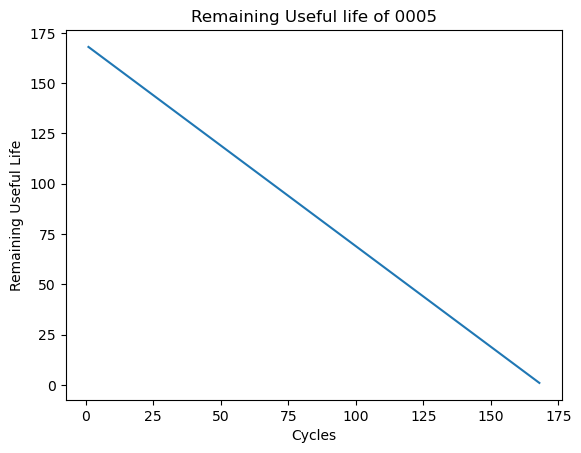

In [30]:
plt.plot(capacity['cycle'], capacity['RUL'])
plt.xlabel('Cycles')
plt.ylabel('Remaining Useful Life')
plt.title('Remaining Useful life of 0005')

## Scaling the data

In [31]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Using train-test split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

## DNN model

In [33]:
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(3,)),
    layers.Dense(16, activation='linear', kernel_regularizer='l2'),
    layers.Dense(8, activation='linear', kernel_regularizer='l2'),
    layers.Dense(1)
])

In [34]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae', 'mse'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/80
5/5 [==============================] - 1s 37ms/step - loss: 85.2450 - mae: 84.9163 - mse: 9611.5527 - val_loss: 84.2941 - val_mae: 83.9668 - val_mse: 9394.6436
Epoch 2/80
5/5 [==============================] - 0s 12ms/step - loss: 85.0403 - mae: 84.7135 - mse: 9578.6660 - val_loss: 84.0786 - val_mae: 83.7529 - val_mse: 9360.1357
Epoch 3/80
5/5 [==============================] - 0s 16ms/step - loss: 84.8383 - mae: 84.5131 - mse: 9546.9639 - val_loss: 83.8642 - val_mae: 83.5398 - val_mse: 9325.5986
Epoch 4/80
5/5 [==============================] - 0s 13ms/step - loss: 84.6303 - mae: 84.3063 - mse: 9515.0312 - val_loss: 83.6389 - val_mae: 83.3153 - val_mse: 9289.3076
Epoch 5/80
5/5 [==============================] - 0s 12ms/step - loss: 84.4149 - mae: 84.0913 - mse: 9481.2188 - val_loss: 83.3908 - val_mae: 83.0672 - val_mse: 9249.8184
Epoch 6/80
5/5 [==============================] - 0s 11ms/step - loss: 84.1808 - mae: 83.8570 - mse: 9443.8613 - val_loss: 83.1063 - val_mae: 82.

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                128       
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


## Learning Curve for RUL

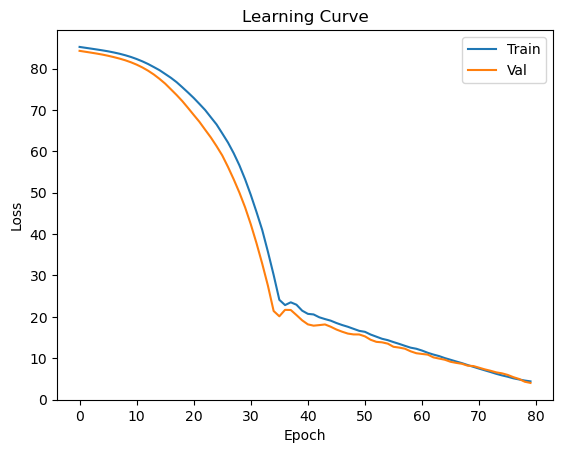

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Model Prediction for RUL

In [37]:
y_pred = model.predict(X_test)

## Visualization of predicted model

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()}).sort_values('Actual',ascending=False)
df

In [39]:
Sample_size=np.arange(0,df.shape[0],1)
Sample_size

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

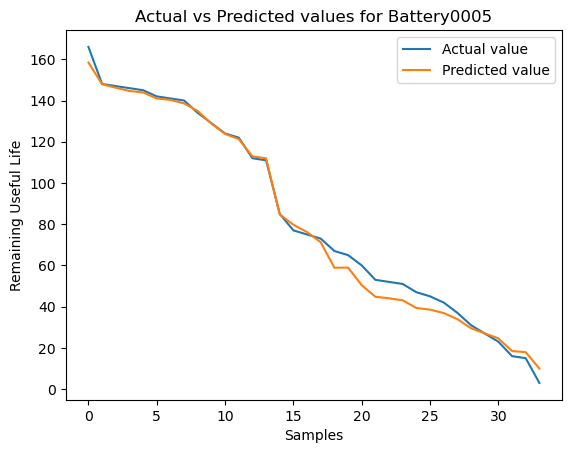

In [40]:
plt.plot(Sample_size, df['Actual'], label='Actual value')
plt.plot(Sample_size, df['Predicted'], label='Predicted value')

plt.title('Actual vs Predicted values for Battery0005')
plt.ylabel('Remaining Useful Life')
plt.xlabel('Samples')
plt.legend()
plt.show()

## Result of RUL

In [41]:
print("R-squared score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))

R-squared score: 0.9914373141553517
Mean Squared Error: 19.725472726162934
Mean Absolute Error: 3.2224754165200626
MAPE: 0.12770039205750733


#Model for Battery 0006

##Importing Capacity dataset

In [42]:
dataset, capacity = load_data('B0006')

Total data in dataset:  616


In [43]:
capacity

,cycle,ambient_temperature,datetime,capacity
0,1,24,2008-04-02 15:25:41,2.035338
1,2,24,2008-04-02 19:43:48,2.025140
2,3,24,2008-04-03 00:01:06,2.013326
3,4,24,2008-04-03 04:16:37,2.013285
4,5,24,2008-04-03 08:33:25,2.000528
...,...,...,...,...
163,164,24,2008-05-26 10:44:38,1.153818
164,165,24,2008-05-26 15:30:43,1.164401
165,166,24,2008-05-26 20:21:04,1.158797
166,167,24,2008-05-27 15:52:41,1.174975


## Getting Shape and size of the Dataset

In [44]:
print("Size of Data: ", capacity.size)
print("Shape of Data: ", capacity.shape)

Size of Data:  672
Shape of Data:  (168, 4)


In [45]:
capacity.describe()

,cycle,ambient_temperature,capacity
count,168.000000,168.0,168.000000
mean,84.500000,24.0,1.546851
std,48.641546,0.0,0.252038
min,1.000000,24.0,1.153818
25%,42.750000,24.0,1.347427
50%,84.500000,24.0,1.485372
75%,126.250000,24.0,1.767208
max,168.000000,24.0,2.035338


In [46]:
capacity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   cycle                168 non-null    int64         
 1   ambient_temperature  168 non-null    int8          
 2   datetime             168 non-null    datetime64[ns]
 3   capacity             168 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), int8(1)
memory usage: 4.2 KB


## Exploaratory Data Analysis

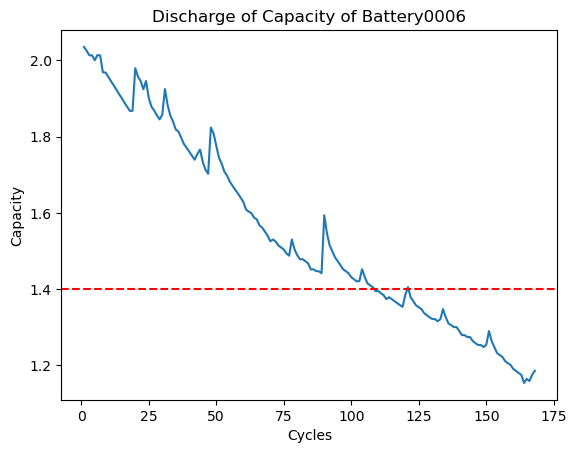

In [47]:
plt.plot(capacity['cycle'], capacity['capacity'])
plt.xlabel('Cycles')
plt.ylabel('Capacity')
plt.title('Discharge of Capacity of Battery0006')
plt.axhline(y=1.4, color='r', linestyle='--')

## Feature selection on basis of Correaltion between variables

In [48]:
corr = capacity['cycle'].corr(capacity['capacity'])
corr

-0.9816806791258748

In [49]:
cormat = capacity.corr()
round(cormat,2)

,cycle,ambient_temperature,capacity
cycle,1.00,NaN,-0.98
ambient_temperature,NaN,NaN,NaN
capacity,-0.98,NaN,1.00


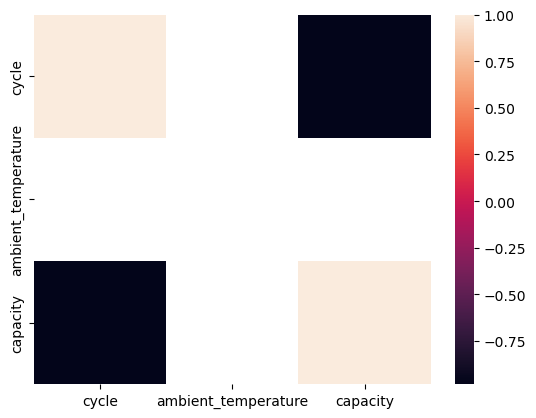

In [50]:
sns.heatmap(cormat);

##Calculating SOH Column for battery

In [51]:
capacity['SOH'] = capacity['capacity'] / capacity['capacity'][0]
capacity

,cycle,ambient_temperature,datetime,capacity,SOH
0,1,24,2008-04-02 15:25:41,2.035338,1.000000
1,2,24,2008-04-02 19:43:48,2.025140,0.994990
2,3,24,2008-04-03 00:01:06,2.013326,0.989185
3,4,24,2008-04-03 04:16:37,2.013285,0.989165
4,5,24,2008-04-03 08:33:25,2.000528,0.982898
...,...,...,...,...,...
163,164,24,2008-05-26 10:44:38,1.153818,0.566893
164,165,24,2008-05-26 15:30:43,1.164401,0.572092
165,166,24,2008-05-26 20:21:04,1.158797,0.569339
166,167,24,2008-05-27 15:52:41,1.174975,0.577287


## Visualization of SOH with respect to number of Cycles

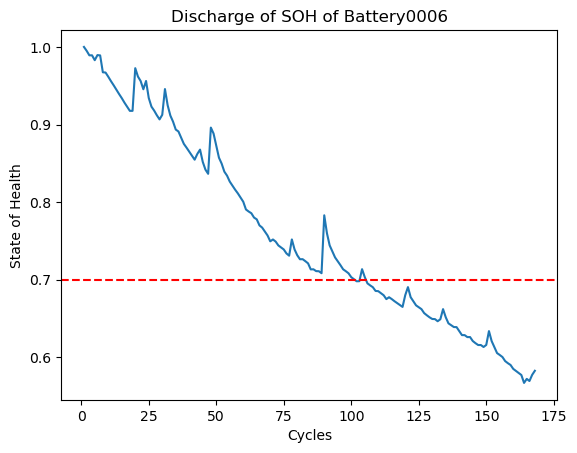

In [52]:
plt.plot(capacity['cycle'], capacity['SOH'])
plt.xlabel('Cycles')
plt.ylabel('State of Health')
plt.title('Discharge of SOH of Battery0006')
plt.axhline(y=0.7, color='r', linestyle='--')

## Data Preparation for model training and Evalution

In [53]:
X = capacity[['cycle', 'capacity']].values
y = capacity['SOH'].values

## Scaling Features

In [54]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Using train-test split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

## DNN model

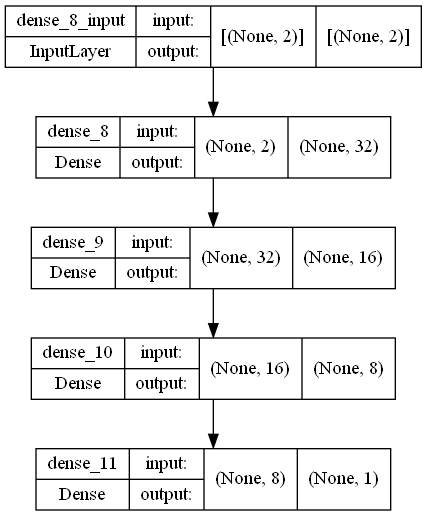

In [56]:
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(2,)),
    layers.Dense(16, activation='relu', kernel_regularizer='l2'),
    layers.Dense(8, activation='linear', kernel_regularizer='l2'),
    layers.Dense(1)
])
plot_model(model, to_file='model_circular.png', show_shapes=True, show_layer_names=True)

In [57]:
model.compile(optimizer='sgd', loss='mean_absolute_error', metrics=['mae', 'mse'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 0s 35ms/step - loss: 1.1794 - mae: 0.8622 - mse: 0.8682 - val_loss: 0.8976 - val_mae: 0.5810 - val_mse: 0.3911
Epoch 2/100
5/5 [==============================] - 0s 11ms/step - loss: 0.7706 - mae: 0.4542 - mse: 0.2529 - val_loss: 0.5350 - val_mae: 0.2189 - val_mse: 0.0660
Epoch 3/100
5/5 [==============================] - 0s 13ms/step - loss: 0.4790 - mae: 0.1630 - mse: 0.0363 - val_loss: 0.3786 - val_mae: 0.0629 - val_mse: 0.0064
Epoch 4/100
5/5 [==============================] - 0s 15ms/step - loss: 0.3920 - mae: 0.0766 - mse: 0.0083 - val_loss: 0.3730 - val_mae: 0.0581 - val_mse: 0.0052
Epoch 5/100
5/5 [==============================] - 0s 13ms/step - loss: 0.3688 - mae: 0.0540 - mse: 0.0044 - val_loss: 0.3442 - val_mae: 0.0298 - val_mse: 0.0017
Epoch 6/100
5/5 [==============================] - 0s 12ms/step - loss: 0.3551 - mae: 0.0409 - mse: 0.0028 - val_loss: 0.3506 - val_mae: 0.0368 - val_mse: 0.0017
Epoch 7/100
5/5 [===========

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                96        
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


## Learning Curve

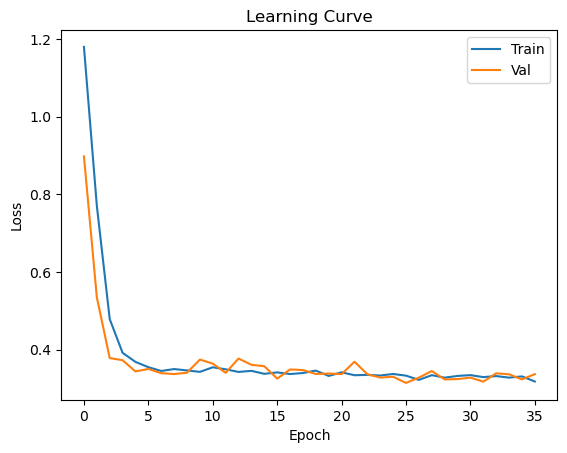

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Model Predicition

In [60]:
y_pred = model.predict(X_test)

## Visulization of Model Prediction

In [61]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()}).sort_values('Actual',ascending=False)
df

,Actual,Predicted
14,0.989185,0.908108
32,0.961781,0.879180
3,0.956097,0.871157
18,0.956016,0.878813
25,0.945419,0.874998
17,0.917934,0.858525
13,0.911900,0.854846
0,0.906582,0.851544
19,0.893483,0.841628
4,0.864953,0.823833


In [62]:
Sample_size=np.arange(0,df.shape[0],1)
Sample_size

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

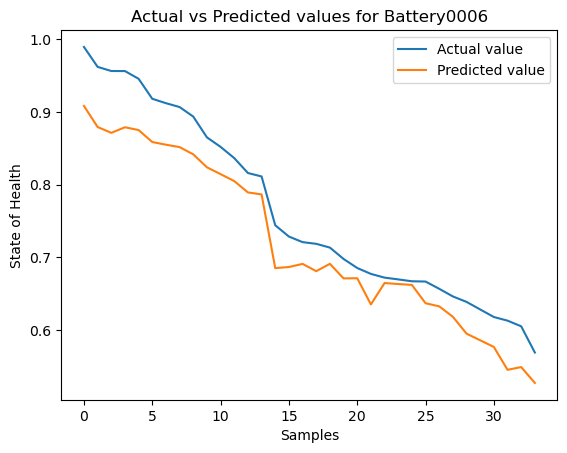

In [63]:
plt.plot(Sample_size, df['Actual'], label='Actual value')
plt.plot(Sample_size, df['Predicted'], label='Predicted value')

plt.title('Actual vs Predicted values for Battery0006')
plt.ylabel('State of Health')
plt.xlabel('Samples')
plt.legend()
plt.show()

## Result of SOH

In [64]:
print("R-squared score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))

R-squared score: 0.8556823813944304
Mean Squared Error: 0.002274480910168119
Mean Absolute Error: 0.04256950218599284
MAPE: 0.054807440038128534


## Calculation of RUL

In [65]:
capacity['RUL'] = capacity['cycle'].size + 1 - capacity['cycle']

In [66]:
capacity

,cycle,ambient_temperature,datetime,capacity,SOH,RUL
0,1,24,2008-04-02 15:25:41,2.035338,1.000000,168
1,2,24,2008-04-02 19:43:48,2.025140,0.994990,167
2,3,24,2008-04-03 00:01:06,2.013326,0.989185,166
3,4,24,2008-04-03 04:16:37,2.013285,0.989165,165
4,5,24,2008-04-03 08:33:25,2.000528,0.982898,164
...,...,...,...,...,...,...
163,164,24,2008-05-26 10:44:38,1.153818,0.566893,5
164,165,24,2008-05-26 15:30:43,1.164401,0.572092,4
165,166,24,2008-05-26 20:21:04,1.158797,0.569339,3
166,167,24,2008-05-27 15:52:41,1.174975,0.577287,2


In [67]:
capacity.describe()

,cycle,ambient_temperature,capacity,SOH,RUL
count,168.000000,168.0,168.000000,168.000000,168.000000
mean,84.500000,24.0,1.546851,0.759997,84.500000
std,48.641546,0.0,0.252038,0.123831,48.641546
min,1.000000,24.0,1.153818,0.566893,1.000000
25%,42.750000,24.0,1.347427,0.662017,42.750000
50%,84.500000,24.0,1.485372,0.729791,84.500000
75%,126.250000,24.0,1.767208,0.868263,126.250000
max,168.000000,24.0,2.035338,1.000000,168.000000


Text(0.5, 1.0, 'Remaining Useful life of Battery0006')

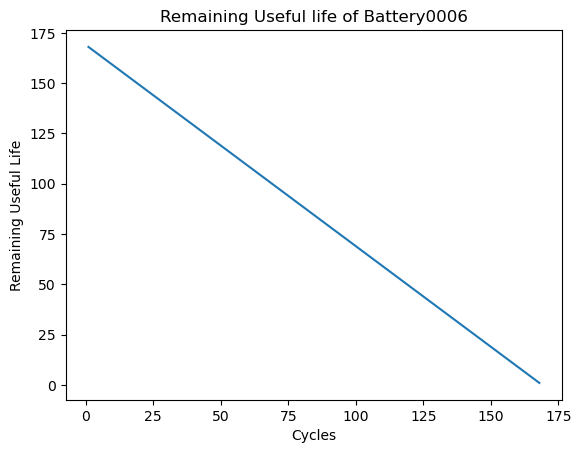

In [68]:
plt.plot(capacity['cycle'], capacity['RUL'])
plt.xlabel('Cycles')
plt.ylabel('Remaining Useful Life')
plt.title('Remaining Useful life of Battery0006')

## Data prepration for model training and testing

In [69]:
X = capacity[['cycle', 'capacity', 'SOH']].values
y = capacity['RUL'].values

## Scaling the data

In [70]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Using train-test split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

## DNN model

In [72]:
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(3,)),
    layers.Dense(16, activation='linear', kernel_regularizer='l2'),
    layers.Dense(8, activation='linear', kernel_regularizer='l2'),
    layers.Dense(1)
])

In [73]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae', 'mse'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/80
5/5 [==============================] - 0s 36ms/step - loss: 84.8011 - mae: 84.4627 - mse: 9537.8193 - val_loss: 83.8534 - val_mae: 83.5164 - val_mse: 9319.0557
Epoch 2/80
5/5 [==============================] - 0s 12ms/step - loss: 84.6350 - mae: 84.2987 - mse: 9513.6172 - val_loss: 83.6653 - val_mae: 83.3303 - val_mse: 9292.5156
Epoch 3/80
5/5 [==============================] - 0s 13ms/step - loss: 84.4561 - mae: 84.1216 - mse: 9488.7930 - val_loss: 83.4673 - val_mae: 83.1339 - val_mse: 9265.4609
Epoch 4/80
5/5 [==============================] - 0s 12ms/step - loss: 84.2678 - mae: 83.9349 - mse: 9463.5791 - val_loss: 83.2529 - val_mae: 82.9207 - val_mse: 9236.5010
Epoch 5/80
5/5 [==============================] - 0s 14ms/step - loss: 84.0698 - mae: 83.7379 - mse: 9436.0693 - val_loss: 83.0170 - val_mae: 82.6855 - val_mse: 9204.4453
Epoch 6/80
5/5 [==============================] - 0s 12ms/step - loss: 83.8471 - mae: 83.5156 - mse: 9406.0420 - val_loss: 82.7773 - val_mae: 82.

In [74]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                128       
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


## Learning Curve for RUL

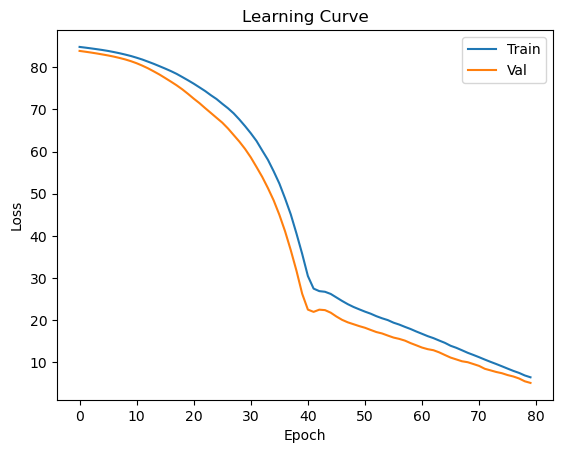

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Model Prediction for RUL

In [76]:
y_pred = model.predict(X_test)

## Visualization of predicted model

In [77]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()}).sort_values('Actual',ascending=False)
df

,Actual,Predicted
14,166,166.900635
32,148,150.536880
18,147,149.216751
25,146,147.428604
3,145,147.701416
17,142,141.719772
13,141,140.373627
0,140,139.096817
19,134,133.258270
4,129,126.686539


In [78]:
Sample_size=np.arange(0,df.shape[0],1)
Sample_size

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

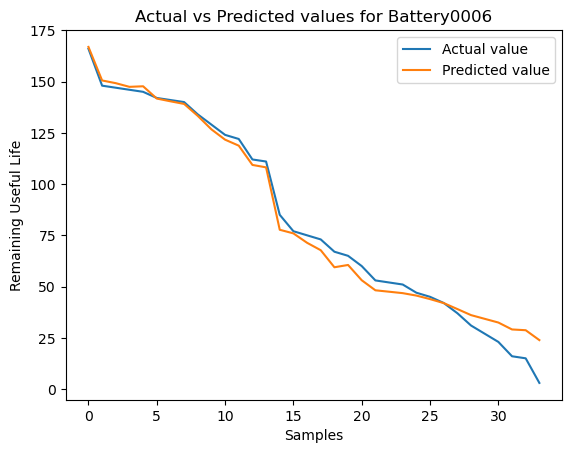

In [79]:
plt.plot(Sample_size, df['Actual'], label='Actual value')
plt.plot(Sample_size, df['Predicted'], label='Predicted value')

plt.title('Actual vs Predicted values for Battery0006')
plt.ylabel('Remaining Useful Life')
plt.xlabel('Samples')
plt.legend()
plt.show()

## Result of RUL

In [80]:
print("R-squared score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))

R-squared score: 0.9832461555038902
Mean Squared Error: 38.595075033955844
Mean Absolute Error: 4.399334178251379
MAPE: 0.3124418804012656


# Model for Battery 0007

##Importing Capacity dataset

In [81]:
dataset, capacity = load_data('B0007')

Total data in dataset:  616


In [82]:
capacity

,cycle,ambient_temperature,datetime,capacity
0,1,24,2008-04-02 15:25:41,1.891052
1,2,24,2008-04-02 19:43:48,1.880637
2,3,24,2008-04-03 00:01:06,1.880663
3,4,24,2008-04-03 04:16:37,1.880771
4,5,24,2008-04-03 08:33:25,1.879451
...,...,...,...,...
163,164,24,2008-05-26 10:44:38,1.406171
164,165,24,2008-05-26 15:30:43,1.406336
165,166,24,2008-05-26 20:21:04,1.400455
166,167,24,2008-05-27 15:52:41,1.421787


## Getting Shape and size of the Dataset

In [83]:
print("Size of Data: ", capacity.size)
print("Shape of Data: ", capacity.shape)

Size of Data:  672
Shape of Data:  (168, 4)


In [84]:
capacity.describe()

,cycle,ambient_temperature,capacity
count,168.000000,168.0,168.000000
mean,84.500000,24.0,1.644421
std,48.641546,0.0,0.160950
min,1.000000,24.0,1.400455
25%,42.750000,24.0,1.498058
50%,84.500000,24.0,1.616125
75%,126.250000,24.0,1.812005
max,168.000000,24.0,1.891052


In [85]:
capacity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   cycle                168 non-null    int64         
 1   ambient_temperature  168 non-null    int8          
 2   datetime             168 non-null    datetime64[ns]
 3   capacity             168 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), int8(1)
memory usage: 4.2 KB


## Exploaratory Data Analysis

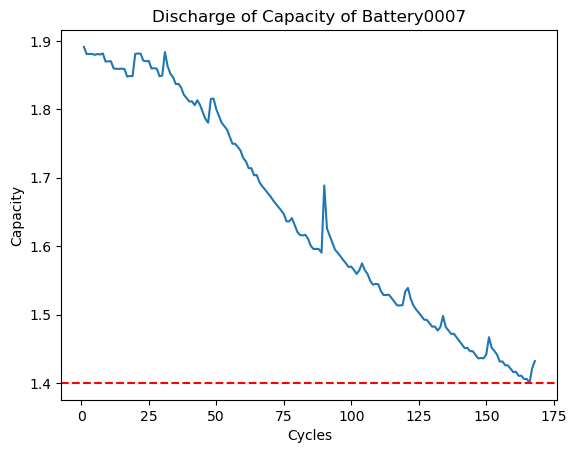

In [86]:
plt.plot(capacity['cycle'], capacity['capacity'])
plt.xlabel('Cycles')
plt.ylabel('Capacity')
plt.title('Discharge of Capacity of Battery0007')
plt.axhline(y=1.4, color='r', linestyle='--')

## Feature selection on basis of Correaltion between variables

In [87]:
corr = capacity['cycle'].corr(capacity['capacity'])
corr

-0.9880849764612359

In [88]:
cormat = capacity.corr()
round(cormat,2)

,cycle,ambient_temperature,capacity
cycle,1.00,NaN,-0.99
ambient_temperature,NaN,NaN,NaN
capacity,-0.99,NaN,1.00


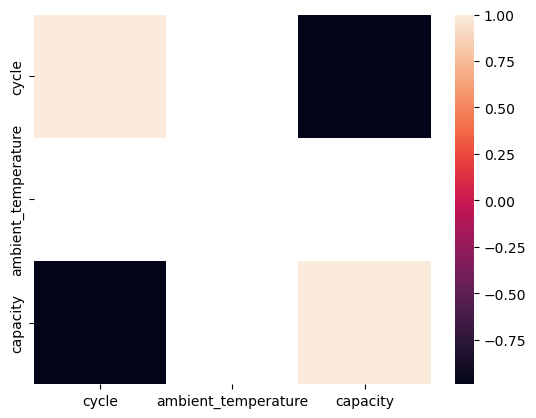

In [89]:
sns.heatmap(cormat);

##Calculating SOH Column for battery

In [90]:
capacity['SOH'] = capacity['capacity'] / capacity['capacity'][0]
capacity

,cycle,ambient_temperature,datetime,capacity,SOH
0,1,24,2008-04-02 15:25:41,1.891052,1.000000
1,2,24,2008-04-02 19:43:48,1.880637,0.994492
2,3,24,2008-04-03 00:01:06,1.880663,0.994506
3,4,24,2008-04-03 04:16:37,1.880771,0.994563
4,5,24,2008-04-03 08:33:25,1.879451,0.993865
...,...,...,...,...,...
163,164,24,2008-05-26 10:44:38,1.406171,0.743592
164,165,24,2008-05-26 15:30:43,1.406336,0.743679
165,166,24,2008-05-26 20:21:04,1.400455,0.740569
166,167,24,2008-05-27 15:52:41,1.421787,0.751849


## Visualization of SOH with respect to number of Cycles

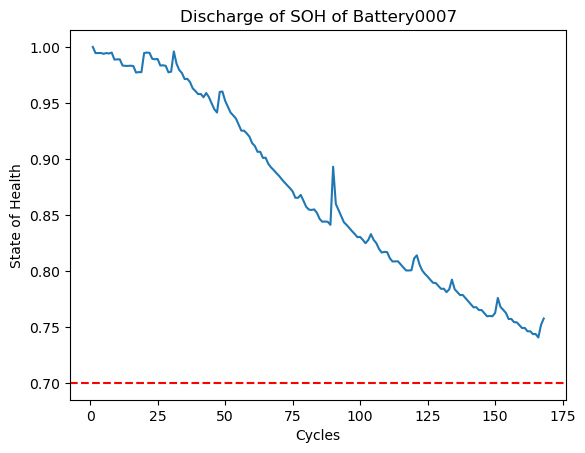

In [91]:
plt.plot(capacity['cycle'], capacity['SOH'])
plt.xlabel('Cycles')
plt.ylabel('State of Health')
plt.title('Discharge of SOH of Battery0007')
plt.axhline(y=0.7, color='r', linestyle='--')

## Data Preparation for model training and Evalution

In [92]:
X = capacity[['cycle', 'capacity']].values
y = capacity['SOH'].values

## Scaling Features

In [93]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Using train-test split

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

## DNN model

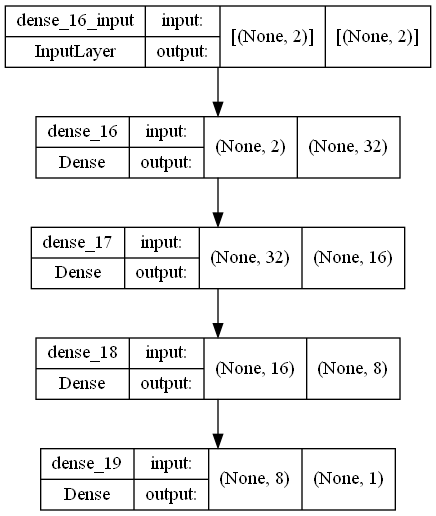

In [95]:
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(2,)),
    layers.Dense(16, activation='relu', kernel_regularizer='l2'),
    layers.Dense(8, activation='linear', kernel_regularizer='l2'),
    layers.Dense(1)
])
plot_model(model, to_file='model_circular.png', show_shapes=True, show_layer_names=True)

In [96]:
model.compile(optimizer='sgd', loss='mean_absolute_error', metrics=['mae', 'mse'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 0s 35ms/step - loss: 1.0203 - mae: 0.6968 - mse: 0.5116 - val_loss: 0.8633 - val_mae: 0.5401 - val_mse: 0.3074
Epoch 2/100
5/5 [==============================] - 0s 14ms/step - loss: 0.8038 - mae: 0.4807 - mse: 0.2540 - val_loss: 0.6355 - val_mae: 0.3125 - val_mse: 0.1125
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 0.5861 - mae: 0.2630 - mse: 0.0956 - val_loss: 0.4831 - val_mae: 0.1603 - val_mse: 0.0416
Epoch 4/100
5/5 [==============================] - 0s 12ms/step - loss: 0.5037 - mae: 0.1811 - mse: 0.0507 - val_loss: 0.4476 - val_mae: 0.1254 - val_mse: 0.0263
Epoch 5/100
5/5 [==============================] - 0s 14ms/step - loss: 0.4796 - mae: 0.1576 - mse: 0.0374 - val_loss: 0.4397 - val_mae: 0.1181 - val_mse: 0.0202
Epoch 6/100
5/5 [==============================] - 0s 11ms/step - loss: 0.4660 - mae: 0.1446 - mse: 0.0294 - val_loss: 0.4380 - val_mae: 0.1171 - val_mse: 0.0191
Epoch 7/100
5/5 [===========

In [97]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                96        
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


## Learning Curve

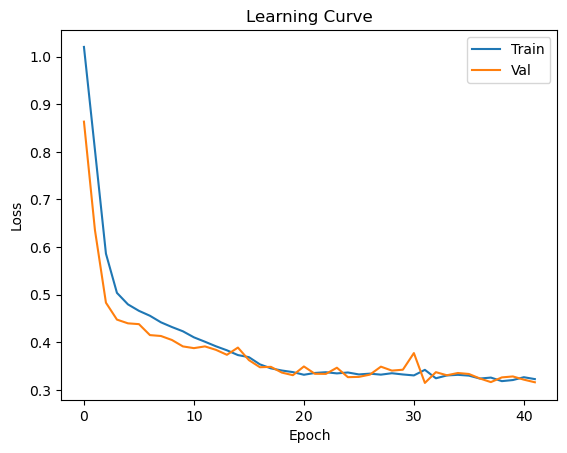

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Model Predicition

In [99]:
y_pred = model.predict(X_test)

## Visulization of Model Prediction

In [100]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()}).sort_values('Actual',ascending=False)
df

,Actual,Predicted
32,0.994934,0.986853
18,0.994735,0.986610
14,0.994506,0.982905
25,0.989401,0.981043
3,0.988973,0.980562
17,0.983597,0.974879
13,0.983138,0.974366
0,0.977308,0.968285
19,0.971326,0.961863
4,0.957870,0.947728


In [101]:
Sample_size=np.arange(0,df.shape[0],1)
Sample_size

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

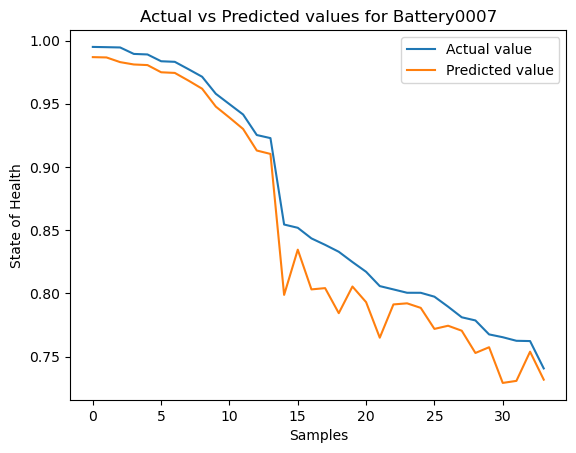

In [102]:
plt.plot(Sample_size, df['Actual'], label='Actual value')
plt.plot(Sample_size, df['Predicted'], label='Predicted value')

plt.title('Actual vs Predicted values for Battery0007')
plt.ylabel('State of Health')
plt.xlabel('Samples')
plt.legend()
plt.show()

## Result of SOH

In [103]:
print("R-squared score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))

R-squared score: 0.93506358787394
Mean Squared Error: 0.0005039420692510855
Mean Absolute Error: 0.01830406722134238
MAPE: 0.021807556163107214


## Calculation of RUL

In [104]:
capacity['RUL'] = capacity['cycle'].size + 1 - capacity['cycle']

In [105]:
capacity

,cycle,ambient_temperature,datetime,capacity,SOH,RUL
0,1,24,2008-04-02 15:25:41,1.891052,1.000000,168
1,2,24,2008-04-02 19:43:48,1.880637,0.994492,167
2,3,24,2008-04-03 00:01:06,1.880663,0.994506,166
3,4,24,2008-04-03 04:16:37,1.880771,0.994563,165
4,5,24,2008-04-03 08:33:25,1.879451,0.993865,164
...,...,...,...,...,...,...
163,164,24,2008-05-26 10:44:38,1.406171,0.743592,5
164,165,24,2008-05-26 15:30:43,1.406336,0.743679,4
165,166,24,2008-05-26 20:21:04,1.400455,0.740569,3
166,167,24,2008-05-27 15:52:41,1.421787,0.751849,2


In [106]:
capacity.describe()

,cycle,ambient_temperature,capacity,SOH,RUL
count,168.000000,168.0,168.000000,168.000000,168.000000
mean,84.500000,24.0,1.644421,0.869580,84.500000
std,48.641546,0.0,0.160950,0.085112,48.641546
min,1.000000,24.0,1.400455,0.740569,1.000000
25%,42.750000,24.0,1.498058,0.792182,42.750000
50%,84.500000,24.0,1.616125,0.854617,84.500000
75%,126.250000,24.0,1.812005,0.958199,126.250000
max,168.000000,24.0,1.891052,1.000000,168.000000


Text(0.5, 1.0, 'Remaining Useful life of Battery0007')

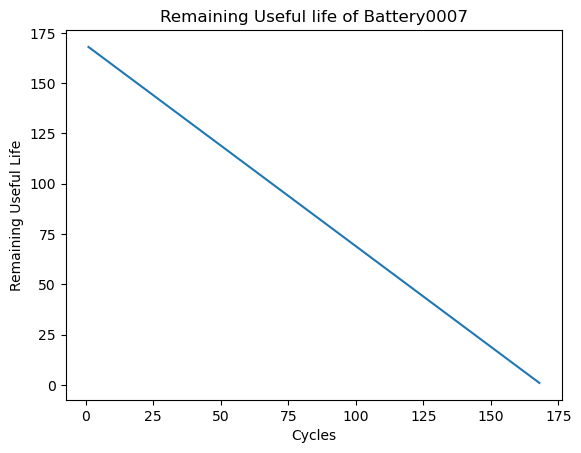

In [107]:
plt.plot(capacity['cycle'], capacity['RUL'])
plt.xlabel('Cycles')
plt.ylabel('Remaining Useful Life')
plt.title('Remaining Useful life of Battery0007')

## Data prepration for model training and testing

In [108]:
X = capacity[['cycle', 'capacity', 'SOH']].values
y = capacity['RUL'].values

## Scaling the data

In [109]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Using train-test split

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

## DNN model

In [111]:
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(3,)),
    layers.Dense(16, activation='linear', kernel_regularizer='l2'),
    layers.Dense(8, activation='linear', kernel_regularizer='l2'),
    layers.Dense(1)
])

In [112]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae', 'mse'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/80
5/5 [==============================] - 0s 35ms/step - loss: 85.3247 - mae: 85.0203 - mse: 9618.7656 - val_loss: 84.3551 - val_mae: 84.0522 - val_mse: 9402.6367
Epoch 2/80
5/5 [==============================] - 0s 13ms/step - loss: 85.0639 - mae: 84.7616 - mse: 9579.1816 - val_loss: 84.0843 - val_mae: 83.7832 - val_mse: 9360.5381
Epoch 3/80
5/5 [==============================] - 0s 13ms/step - loss: 84.8074 - mae: 84.5068 - mse: 9541.4502 - val_loss: 83.8168 - val_mae: 83.5170 - val_mse: 9319.0361
Epoch 4/80
5/5 [==============================] - 0s 11ms/step - loss: 84.5550 - mae: 84.2556 - mse: 9503.2471 - val_loss: 83.5404 - val_mae: 83.2415 - val_mse: 9276.6270
Epoch 5/80
5/5 [==============================] - 0s 12ms/step - loss: 84.2947 - mae: 83.9959 - mse: 9464.0869 - val_loss: 83.2418 - val_mae: 82.9432 - val_mse: 9231.7842
Epoch 6/80
5/5 [==============================] - 0s 11ms/step - loss: 84.0115 - mae: 83.7127 - mse: 9420.8311 - val_loss: 82.9072 - val_mae: 82.

In [113]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 32)                128       
                                                                 
 dense_21 (Dense)            (None, 16)                528       
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


## Learning Curve for RUL

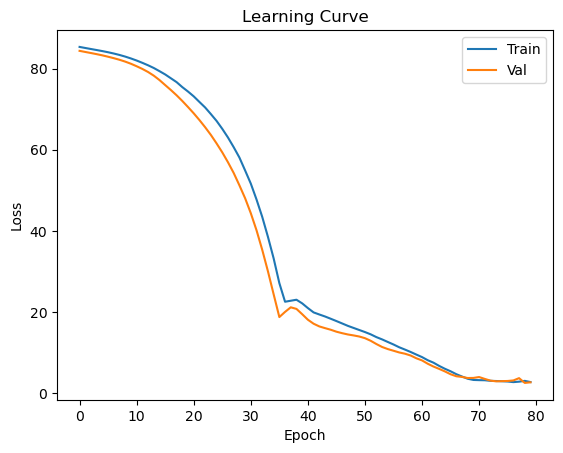

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Model Prediction for RUL

In [115]:
y_pred = model.predict(X_test)

## Visualization of predicted model

In [116]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()}).sort_values('Actual',ascending=False)
df

,Actual,Predicted
14,166,164.595596
32,148,146.443329
18,147,145.441055
25,146,144.580673
3,145,143.584686
17,142,140.709869
13,141,139.714752
0,140,138.868118
19,134,132.986649
4,129,128.319595


In [117]:
Sample_size=np.arange(0,df.shape[0],1)
Sample_size

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

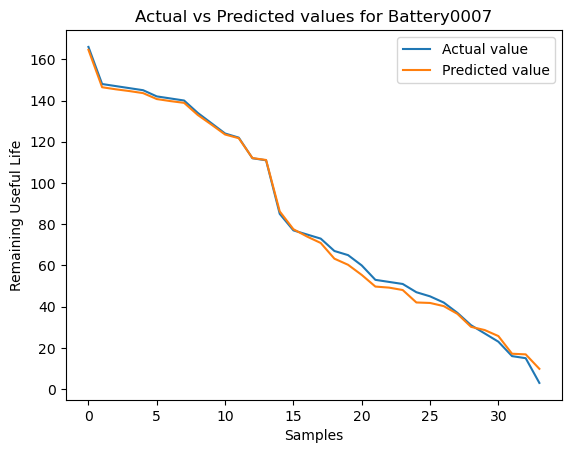

In [118]:
plt.plot(Sample_size, df['Actual'], label='Actual value')
plt.plot(Sample_size, df['Predicted'], label='Predicted value')

plt.title('Actual vs Predicted values for Battery0007')
plt.ylabel('Remaining Useful Life')
plt.xlabel('Samples')
plt.legend()
plt.show()

## Result of RUL

In [119]:
print("R-squared score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))

R-squared score: 0.997330035286197
Mean Squared Error: 6.150677147037347
Mean Absolute Error: 1.9429515109342688
MAPE: 0.10148972511084904


#Model for Battery 0018

##Importing Capacity dataset

In [120]:
dataset, capacity = load_data('B0018')

Total data in dataset:  319


In [121]:
capacity

,cycle,ambient_temperature,datetime,capacity
0,1,24,2008-07-07 15:15:28,1.855005
1,2,24,2008-07-07 21:53:06,1.843196
2,3,24,2008-07-08 02:56:08,1.839602
3,4,24,2008-07-08 07:58:55,1.830674
4,5,24,2008-07-08 18:57:48,1.832700
...,...,...,...,...
127,128,24,2008-08-19 16:54:51,1.362737
128,129,24,2008-08-19 20:32:20,1.363405
129,130,24,2008-08-20 00:43:05,1.351865
130,131,24,2008-08-20 05:02:00,1.354797


## Getting Shape and size of the Dataset

In [122]:
print("Size of Data: ", capacity.size)
print("Shape of Data: ", capacity.shape)

Size of Data:  528
Shape of Data:  (132, 4)


In [123]:
capacity.describe()

,cycle,ambient_temperature,capacity
count,132.000000,132.0,132.000000
mean,66.500000,24.0,1.557701
std,38.249183,0.0,0.154885
min,1.000000,24.0,1.341051
25%,33.750000,24.0,1.415288
50%,66.500000,24.0,1.531892
75%,99.250000,24.0,1.684936
max,132.000000,24.0,1.855005


In [124]:
capacity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   cycle                132 non-null    int64         
 1   ambient_temperature  132 non-null    int8          
 2   datetime             132 non-null    datetime64[ns]
 3   capacity             132 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), int8(1)
memory usage: 3.3 KB


## Exploaratory Data Analysis

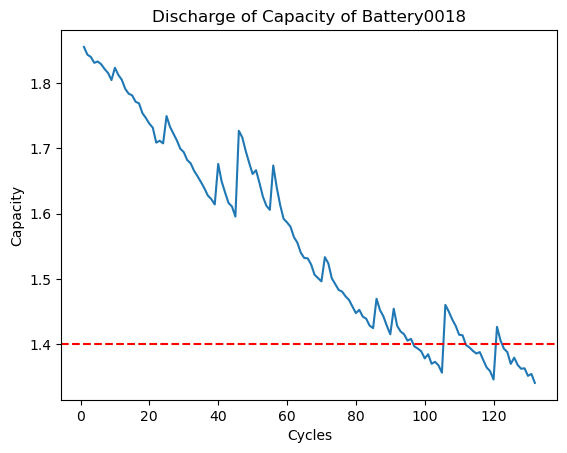

In [125]:
plt.plot(capacity['cycle'], capacity['capacity'])
plt.xlabel('Cycles')
plt.ylabel('Capacity')
plt.title('Discharge of Capacity of Battery0018')
plt.axhline(y=1.4, color='r', linestyle='--')

## Feature selection on basis of Correaltion between variables

In [126]:
corr = capacity['cycle'].corr(capacity['capacity'])
corr

-0.9695720607260047

In [127]:
cormat = capacity.corr()
round(cormat,2)

,cycle,ambient_temperature,capacity
cycle,1.00,NaN,-0.97
ambient_temperature,NaN,NaN,NaN
capacity,-0.97,NaN,1.00


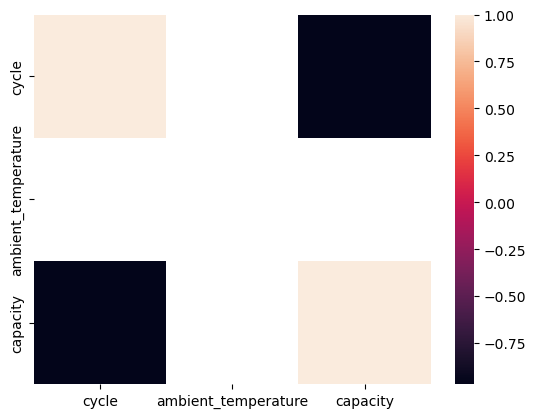

In [128]:
sns.heatmap(cormat);

##Calculating SOH Column for battery

In [129]:
capacity['SOH'] = capacity['capacity'] / capacity['capacity'][0]
capacity

,cycle,ambient_temperature,datetime,capacity,SOH
0,1,24,2008-07-07 15:15:28,1.855005,1.000000
1,2,24,2008-07-07 21:53:06,1.843196,0.993634
2,3,24,2008-07-08 02:56:08,1.839602,0.991697
3,4,24,2008-07-08 07:58:55,1.830674,0.986884
4,5,24,2008-07-08 18:57:48,1.832700,0.987976
...,...,...,...,...,...
127,128,24,2008-08-19 16:54:51,1.362737,0.734627
128,129,24,2008-08-19 20:32:20,1.363405,0.734987
129,130,24,2008-08-20 00:43:05,1.351865,0.728766
130,131,24,2008-08-20 05:02:00,1.354797,0.730347


## Visualization of SOH with respect to number of Cycles

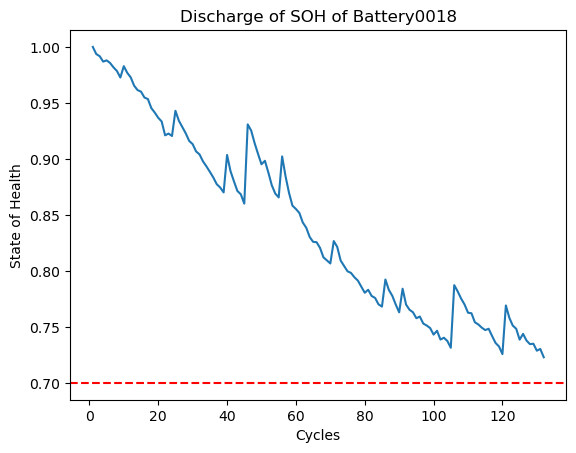

In [130]:
plt.plot(capacity['cycle'], capacity['SOH'])
plt.xlabel('Cycles')
plt.ylabel('State of Health')
plt.title('Discharge of SOH of Battery0018')
plt.axhline(y=0.7, color='r', linestyle='--')

## Data Preparation for model training and Evalution

In [131]:
X = capacity[['cycle', 'capacity']].values
y = capacity['SOH'].values

## Scaling Features

In [132]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Using train-test split

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

## DNN model

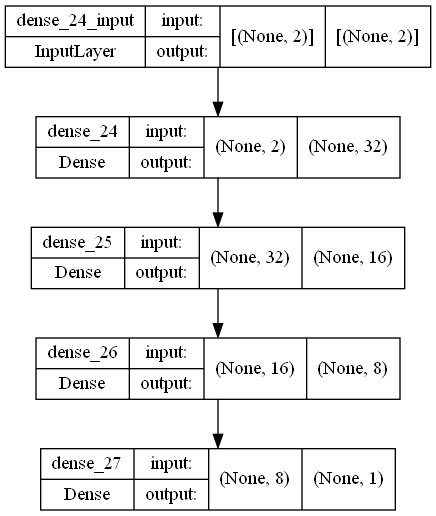

In [134]:
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(2,)),
    layers.Dense(16, activation='relu', kernel_regularizer='l2'),
    layers.Dense(8, activation='linear', kernel_regularizer='l2'),
    layers.Dense(1)
])
plot_model(model, to_file='model_circular.png', show_shapes=True, show_layer_names=True)

In [135]:
model.compile(optimizer='sgd', loss='mean_absolute_error', metrics=['mae', 'mse'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
4/4 [==============================] - 0s 45ms/step - loss: 1.0457 - mae: 0.7137 - mse: 0.5217 - val_loss: 0.8646 - val_mae: 0.5329 - val_mse: 0.3132
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8128 - mae: 0.4811 - mse: 0.2638 - val_loss: 0.6691 - val_mae: 0.3376 - val_mse: 0.1572
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6700 - mae: 0.3387 - mse: 0.1439 - val_loss: 0.6077 - val_mae: 0.2768 - val_mse: 0.0962
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5932 - mae: 0.2625 - mse: 0.0841 - val_loss: 0.5520 - val_mae: 0.2217 - val_mse: 0.0560
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.5242 - mae: 0.1941 - mse: 0.0456 - val_loss: 0.4845 - val_mae: 0.1548 - val_mse: 0.0271
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.4550 - mae: 0.1255 - mse: 0.0197 - val_loss: 0.4156 - val_mae: 0.0865 - val_mse: 0.0102
Epoch 7/100
4/4 [===========

In [136]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 32)                96        
                                                                 
 dense_25 (Dense)            (None, 16)                528       
                                                                 
 dense_26 (Dense)            (None, 8)                 136       
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


## Learning Curve

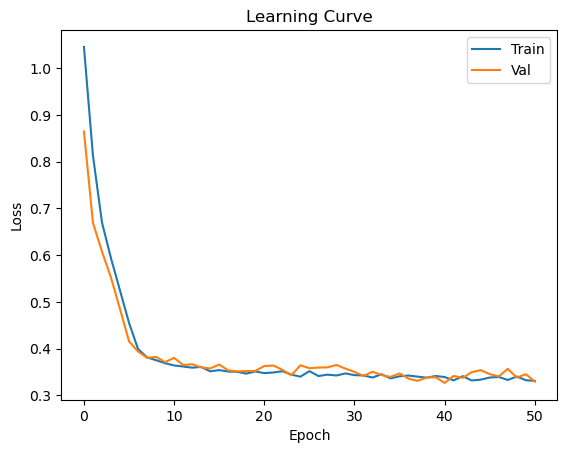

In [137]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Model Predicition

In [138]:
y_pred = model.predict(X_test)

## Visulization of Model Prediction

In [139]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()}).sort_values('Actual',ascending=False)
df

,Actual,Predicted
22,0.991697,0.982301
21,0.985727,0.974960
10,0.961437,0.953685
24,0.933430,0.937105
13,0.925371,0.860222
14,0.922826,0.917246
0,0.922623,0.934826
12,0.921073,0.939036
20,0.920484,0.932246
16,0.916045,0.916581


In [140]:
Sample_size=np.arange(0,df.shape[0],1)
Sample_size

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

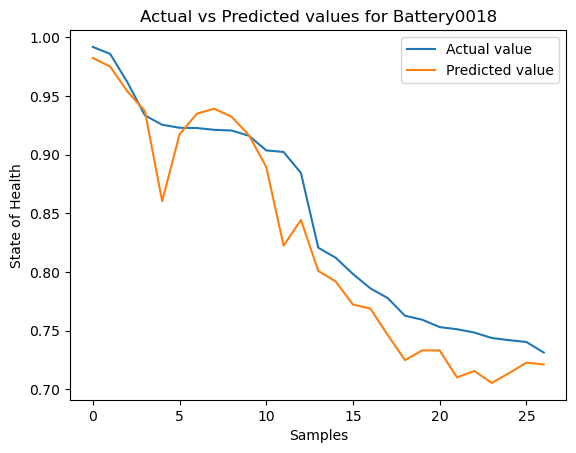

In [141]:
plt.plot(Sample_size, df['Actual'], label='Actual value')
plt.plot(Sample_size, df['Predicted'], label='Predicted value')

plt.title('Actual vs Predicted values for Battery0018')
plt.ylabel('State of Health')
plt.xlabel('Samples')
plt.legend()
plt.show()

## Result of SOH

In [142]:
print("R-squared score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))

R-squared score: 0.8818845916586385
Mean Squared Error: 0.0008895501234097575
Mean Absolute Error: 0.02388831099186954
MAPE: 0.029028657198712268


## Calculation of RUL

In [143]:
capacity['RUL'] = capacity['cycle'].size + 1 - capacity['cycle']

In [144]:
capacity

,cycle,ambient_temperature,datetime,capacity,SOH,RUL
0,1,24,2008-07-07 15:15:28,1.855005,1.000000,132
1,2,24,2008-07-07 21:53:06,1.843196,0.993634,131
2,3,24,2008-07-08 02:56:08,1.839602,0.991697,130
3,4,24,2008-07-08 07:58:55,1.830674,0.986884,129
4,5,24,2008-07-08 18:57:48,1.832700,0.987976,128
...,...,...,...,...,...,...
127,128,24,2008-08-19 16:54:51,1.362737,0.734627,5
128,129,24,2008-08-19 20:32:20,1.363405,0.734987,4
129,130,24,2008-08-20 00:43:05,1.351865,0.728766,3
130,131,24,2008-08-20 05:02:00,1.354797,0.730347,2


In [145]:
capacity.describe()

,cycle,ambient_temperature,capacity,SOH,RUL
count,132.000000,132.0,132.000000,132.000000,132.000000
mean,66.500000,24.0,1.557701,0.839729,66.500000
std,38.249183,0.0,0.154885,0.083496,38.249183
min,1.000000,24.0,1.341051,0.722937,1.000000
25%,33.750000,24.0,1.415288,0.762957,33.750000
50%,66.500000,24.0,1.531892,0.825816,66.500000
75%,99.250000,24.0,1.684936,0.908319,99.250000
max,132.000000,24.0,1.855005,1.000000,132.000000


Text(0.5, 1.0, 'Remaining Useful life of Battery0018')

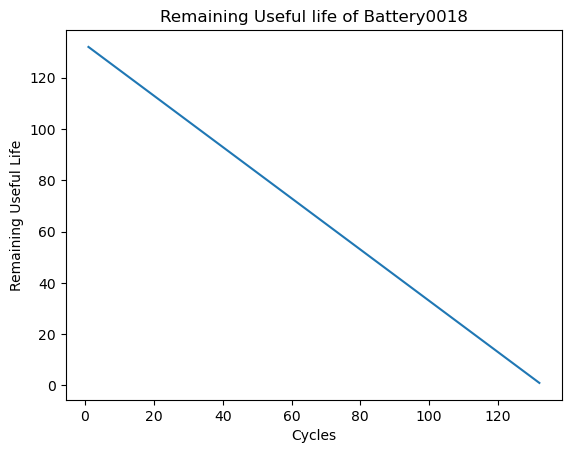

In [146]:
plt.plot(capacity['cycle'], capacity['RUL'])
plt.xlabel('Cycles')
plt.ylabel('Remaining Useful Life')
plt.title('Remaining Useful life of Battery0018')

## Data prepration for model training and testing

In [147]:
X = capacity[['cycle', 'capacity', 'SOH']].values
y = capacity['RUL'].values

## Scaling the data

In [148]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Using train-test split

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

## DNN model

In [150]:
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(3,)),
    layers.Dense(16, activation='linear', kernel_regularizer='l2'),
    layers.Dense(8, activation='linear', kernel_regularizer='l2'),
    layers.Dense(1)
])

In [151]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae', 'mse'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/80
4/4 [==============================] - 0s 45ms/step - loss: 66.4088 - mae: 66.0857 - mse: 5837.0698 - val_loss: 68.8153 - val_mae: 68.4932 - val_mse: 6257.0913
Epoch 2/80
4/4 [==============================] - 0s 15ms/step - loss: 66.1619 - mae: 65.8402 - mse: 5801.1323 - val_loss: 68.5586 - val_mae: 68.2379 - val_mse: 6219.4512
Epoch 3/80
4/4 [==============================] - 0s 13ms/step - loss: 65.9326 - mae: 65.6123 - mse: 5769.3950 - val_loss: 68.3030 - val_mae: 67.9835 - val_mse: 6181.6772
Epoch 4/80
4/4 [==============================] - 0s 14ms/step - loss: 65.7078 - mae: 65.3886 - mse: 5737.1538 - val_loss: 68.0403 - val_mae: 67.7217 - val_mse: 6143.0288
Epoch 5/80
4/4 [==============================] - 0s 15ms/step - loss: 65.4691 - mae: 65.1507 - mse: 5703.1577 - val_loss: 67.7687 - val_mae: 67.4506 - val_mse: 6103.2769
Epoch 6/80
4/4 [==============================] - 0s 15ms/step - loss: 65.2284 - mae: 64.9104 - mse: 5668.3047 - val_loss: 67.4809 - val_mae: 67.

In [152]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 32)                128       
                                                                 
 dense_29 (Dense)            (None, 16)                528       
                                                                 
 dense_30 (Dense)            (None, 8)                 136       
                                                                 
 dense_31 (Dense)            (None, 1)                 9         
                                                                 
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


## Learning Curve for RUL

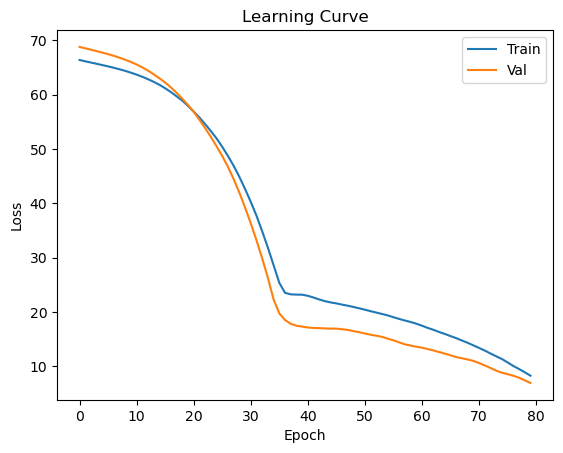

In [153]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Model Prediction for RUL

In [154]:
y_pred = model.predict(X_test)

## Visualization of predicted model

In [155]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()}).sort_values('Actual',ascending=False)
df

,Actual,Predicted
22,130,136.754700
21,127,133.204437
10,119,121.161491
24,112,108.749825
12,111,104.665901
0,110,104.525803
20,109,103.339584
14,105,101.685196
16,104,99.182556
18,93,89.809494


In [156]:
Sample_size=np.arange(0,df.shape[0],1)
Sample_size

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

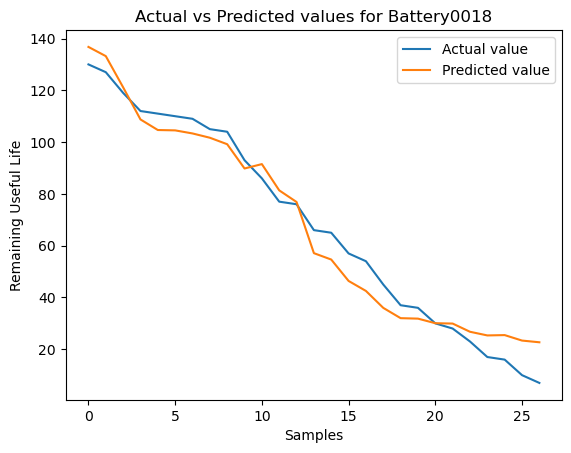

In [157]:
plt.plot(Sample_size, df['Actual'], label='Actual value')
plt.plot(Sample_size, df['Predicted'], label='Predicted value')

plt.title('Actual vs Predicted values for Battery0018')
plt.ylabel('Remaining Useful Life')

plt.xlabel('Samples')
plt.legend()
plt.show()

## Result of RUL

In [158]:
print("R-squared score:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))

R-squared score: 0.9647606353129766
Mean Squared Error: 53.78667859204951
Mean Absolute Error: 6.297243895354094
MAPE: 0.24406159634155986
